# Import modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
import sklearn

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.utils import normalize
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras import backend as K
from keras import callbacks
import cv2

# Import data

In [ ]:
# import data
!unzip /content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/original_images.zip
!unzip /content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/combined_masks.zip

In [ ]:
# !rm -rf /content/combined_masks/

In [ ]:
image_directory = '/content/original_images'
mask_directory = '/content/combined_masks'
prediction_directory = '/content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/PredictionImages/'

## Get data functions

In [ ]:
# get image and mask data for k-fold cross validation
def getTest(TestSubName, path):
    # if type == 'Mask':
      dataset = []
      # print((TestSubName[0]))
      all_images = glob.glob(os.path.join(path, TestSubName[0]+'*'))
      # print(all_images)
      for i, image_name in enumerate(all_images):
        image = cv2.imread(image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
      dataset = np.expand_dims((np.array(dataset)), 3) / 255.0
      return dataset

def getTrain(restSubName, path):  
    # if type == 'Train':
      dataset = []
      for i, rest_sub_name in enumerate(restSubName):
        # print(rest_sub_name)
        all_images = glob.glob(os.path.join(path, rest_sub_name+'*'))
        # print(all_images)
        for i, image_name in enumerate(all_images):
          image = cv2.imread(image_name, 0)
          # print(image)
          image = Image.fromarray(image)
          image = image.resize((SIZE, SIZE))
          dataset.append(np.array(image))
      dataset = np.expand_dims((np.array(dataset)), 3) / 255.0
      return dataset

In [ ]:
SIZE = 256
image_dataset = []
mask_dataset = []

In [ ]:
# check if getTrain and getTest functions worked
Y = ['T0012', 'T0013', 'T0014']
for i, testSubName in enumerate(Y):
  testSubName = [testSubName]
  trainSubName = list(set(Y)-set(testSubName))
  print('testsub: ', testSubName, 'restSubNames: ', trainSubName)
  x_train = getTrain(trainSubName, image_directory)
  y_train = getTrain(trainSubName, mask_directory)
  x_test = getTest(testSubName, image_directory)
  y_test = getTest(testSubName, mask_directory)
  print(x_train.shape, x_test.shape)

testsub:  ['T0012'] restSubNames:  ['T0014', 'T0013']
(276, 256, 256, 1) (146, 256, 256, 1)
testsub:  ['T0013'] restSubNames:  ['T0014', 'T0012']
(283, 256, 256, 1) (139, 256, 256, 1)
testsub:  ['T0014'] restSubNames:  ['T0013', 'T0012']
(285, 256, 256, 1) (137, 256, 256, 1)


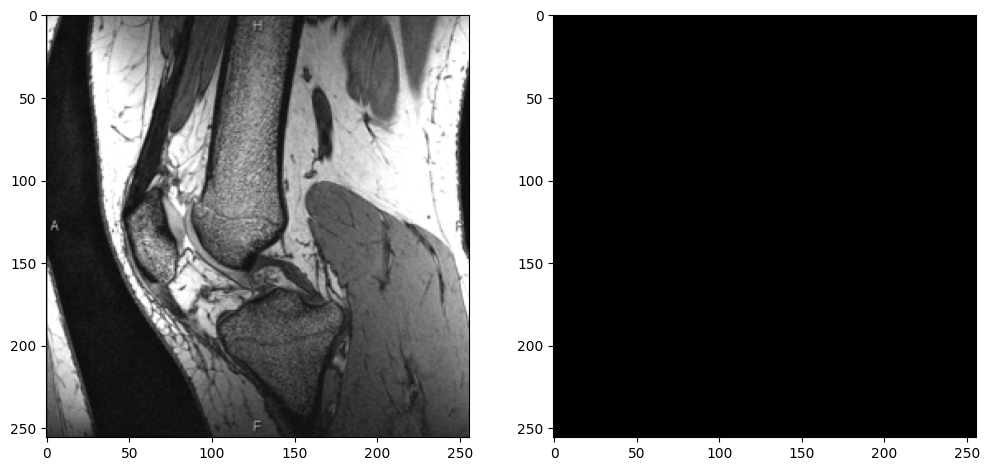

In [ ]:
# randomly import an image and a label to check
import random
image_number = random.randint(0, len(x_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(x_test[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_test[image_number], (256, 256)), cmap='gray')
plt.show()

In [ ]:
# define image height, width, and channel
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 1

# Build model

## Define losses

In [ ]:
# Define losses
def DiceCoef(y_true, y_pred, smooth=1):
    # # y_pred_thresholded = y_pred > 0.5
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    # dice = np.array(dice)
    return dice


def DiceLoss(y_true, y_pred, smooth=1):
    print(y_true.shape, y_pred.shape)
    return 1 - DiceCoef(y_true, y_pred)


def DiceBCELoss(targets, inputs, smooth=1):
    # flatten label and prediction tensors
    # targets = K.flatten(targets)
    # inputs = K.flatten(inputs)
    BCE = K.binary_crossentropy(targets, inputs)
    BCE = tf.math.reduce_mean(BCE,axis=(1,2,3))
    # print(BCE.shape)
    intersection = tf.math.reduce_sum((targets * inputs),axis = (1,2,3))
    # print(intersection.shape)
    # print(intersection)
    dice_loss = 1 - (2 * intersection + smooth) / (tf.math.reduce_sum(targets,axis = (1,2,3)) + tf.math.reduce_sum(inputs,axis = (1,2,3)) + smooth)
    # print(dice_loss.shape)
    Dice_BCE = BCE + dice_loss
    return Dice_BCE

## Building 2-D UNet model

In [ ]:
# build the 2-D unet model
def unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # l1 = Lambda(lambda x: x / 255)(inputs)
    s = inputs

    # encoding
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    # p5 = MaxPooling2D((2,2))(c5)

    # decoding
    d6 = Conv2DTranspose(128, (2,2), strides=2, padding='same')(c5)
    d6 = concatenate([d6, c4]) # d6=d6+c4
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(d6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    d7 = Conv2DTranspose(64, (2,2), strides=2, padding='same')(c6)
    d7 = concatenate([d7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(d7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    d8 = Conv2DTranspose(64, (2,2), strides=2, padding='same')(c7)
    d8 = concatenate([d8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(d8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    d9 = Conv2DTranspose(16, (2,2), strides=2, padding='same')(c8)
    d9 = concatenate([d9, c1])
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(d9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

    return Model(inputs=[inputs], outputs=[outputs])

In [ ]:
# checking if load trian and test data function is working. You can skip this step
Y = ['T0012', 'T0013', 'T0014']
# fold_var = 2
testSubName = 'T0013'
# for i, testSubName in enumerate(Y): # uncomment if using k-fold
testSubName = [testSubName]
trainSubName = list(set(Y)-set(testSubName))
print('testsub: ', testSubName, 'trainSubNames: ', trainSubName)
x_train = getTrain(trainSubName, image_directory)
y_train = getTrain(trainSubName, mask_directory)
x_test = getTest(testSubName, image_directory)
y_test = getTest(testSubName, mask_directory)
print(x_train.shape, x_test.shape)

testsub:  ['T0013'] trainSubNames:  ['T0014', 'T0012']
(283, 256, 256, 1) (139, 256, 256, 1)


## Custom fit function to allow more flexible training 


*   Learning rate scheduler
*   Saving the best models



In [ ]:
# define a customfit for more flexible manipulation
def CustomFit(batch_size, optimizer, model, train_dataset,
              val_dataset, epochs, fold_var):
    # partial code https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
    total_loss = []
    bce_loss = []
    mean_dsc_epoch = []
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        # learning rate scheduler for better gradient descent
        if (epoch+1) % 30 == 0:
            optimizer.lr = optimizer.lr *0.2
            print('Learning rate at: ', optimizer.lr)
        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:
                # Run the forward pass of the layer.
                # The operations that the layer applies
                # to its inputs are going to be recorded
                # on the GradientTape.
                logits = model(x_batch_train)  # Logits for this minibatch
                # print(logits.dtype,y_batch_train.dtype)
                y_batch_train = tf.cast(y_batch_train, dtype='float32')
                # Compute the loss value for this minibatch.
                  loss_value = DiceBCELoss(y_batch_train, logits)
                loss_value = tf.math.reduce_mean(loss_value)
                bce = K.binary_crossentropy(y_batch_train, logits)
                bce = tf.math.reduce_mean(bce)
            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_weights)

            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            # Log every 20 batches.
            if step % 20 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, float(loss_value))
                )
                # print("Seen so far: %s samples" % ((step + 1) * batch_size))
        dsc_ls = []
        for x_batch_val, y_batch_val in val_dataset:
                val_logits = model(x_batch_val)
                # Update val metrics
                y_batch_val = tf.cast(y_batch_val, dtype='float32')
                y_pred = tf.cast((val_logits>0.5), dtype='float32')
                dsc = DiceCoef(y_batch_val,y_pred)
                dsc_ls.append(dsc.numpy())
        print('total dice for this epoch is: ', np.mean(dsc_ls))
        mean_dsc_epoch.append(np.mean(dsc_ls))
        # print(float(loss_value))
        total_loss.append(float(loss_value))
        bce_loss.append(bce.numpy().item())
        # Compare metric and save best models
        if epoch > 2:
            if mean_dsc_epoch[-1] > max(mean_dsc_epoch[:-1]):
                model.save('/content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/TrainedModels/meniscus_epoch80_f'+ str(fold_var)+'_dce_'+
                           str(round(mean_dsc_epoch[-1], 2))+'.hdf5') #save models to a folder in your drive so that we can call it in the future
                print("Model with dsc",mean_dsc_epoch[-1],"saved")
    return total_loss, mean_dsc_epoch, bce_loss

# Training & Testing

## 3-Folds cross-validation

In [ ]:
# UNet with 3-fold (leave-one-out) cross-validation
Y = ['T0012', 'T0013', 'T0014']
fold_var = 0
kfold_hist = []
for i, testSubName in enumerate(Y):
    fold_var += 1
    print('Training iteration', fold_var)
    testSubName = [testSubName]
    trainSubName = list(set(Y)-set(testSubName))
    print('testsub: ', testSubName, 'trainSubNames: ', trainSubName)
    x_train = getTrain(trainSubName, image_directory)
    y_train = getTrain(trainSubName, mask_directory)
    x_test = getTest(testSubName, image_directory)
    y_test = getTest(testSubName, mask_directory)
    print(x_train.shape, x_test.shape)

    batch_size = 8
    optimizer = keras.optimizers.Adam(lr=0.01) # player around with the learning rate and see which one gives the best result
    model = unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    val_dataset = val_dataset.batch(1)
    epochs = 80

    hist = CustomFit(batch_size, optimizer, model, train_dataset, val_dataset, epochs, fold_var)
    kfold_hist.append(hist)

Training iteration 1
testsub:  ['T0012'] trainSubNames:  ['T0014', 'T0013']
(276, 256, 256, 1) (146, 256, 256, 1)



Start of epoch 0


Training loss (for one batch) at step 0: 1.7769
Training loss (for one batch) at step 20: 1.0064
total dice for this epoch is:  0.31903958

Start of epoch 1
Training loss (for one batch) at step 0: 0.6560
Training loss (for one batch) at step 20: 0.2638
total dice for this epoch is:  0.31903958

Start of epoch 2
Training loss (for one batch) at step 0: 0.7636
Training loss (for one batch) at step 20: 0.8826
total dice for this epoch is:  0.31903958

Start of epoch 3
Training loss (for one batch) at step 0: 0.7715
Training loss (for one batch) at step 20: 0.7642
total dice for this epoch is:  0.31903958

Start of epoch 4
Training loss (for one batch) at step 0: 0.6382
Training loss (for one batch) at step 20: 0.7668
total dice for this epoch is:  0.31903958

Start of epoch 5
Training loss (for one batch) at step 0: 0.7695
Training loss (for one batch) at step 20: 0.7623
total dice for this epoch is:  0.31903958

Start of epoch 6
Training loss (for one batch) at step 0: 0.6354
Training l

total dice for this epoch is:  0.44949222
Model with dsc 0.44949222 saved

Start of epoch 16
Training loss (for one batch) at step 0: 0.5372
Training loss (for one batch) at step 20: 0.7896
total dice for this epoch is:  0.37860477

Start of epoch 17
Training loss (for one batch) at step 0: 0.6772
Training loss (for one batch) at step 20: 0.7110


total dice for this epoch is:  0.46964106
Model with dsc 0.46964106 saved

Start of epoch 18
Training loss (for one batch) at step 0: 0.4606
Training loss (for one batch) at step 20: 0.3782
total dice for this epoch is:  0.3245468

Start of epoch 19
Training loss (for one batch) at step 0: 0.9137
Training loss (for one batch) at step 20: 0.3646


total dice for this epoch is:  0.53083485
Model with dsc 0.53083485 saved

Start of epoch 20
Training loss (for one batch) at step 0: 0.3236
Training loss (for one batch) at step 20: 0.1896
total dice for this epoch is:  0.43494892

Start of epoch 21
Training loss (for one batch) at step 0: 0.5059
Training loss (for one batch) at step 20: 0.3678


total dice for this epoch is:  0.5942299
Model with dsc 0.5942299 saved

Start of epoch 22
Training loss (for one batch) at step 0: 0.1480
Training loss (for one batch) at step 20: 0.2646
total dice for this epoch is:  0.5918357

Start of epoch 23
Training loss (for one batch) at step 0: 0.3770
Training loss (for one batch) at step 20: 0.2449


total dice for this epoch is:  0.59549886
Model with dsc 0.59549886 saved

Start of epoch 24
Training loss (for one batch) at step 0: 0.4139
Training loss (for one batch) at step 20: 0.1413
total dice for this epoch is:  0.475124

Start of epoch 25
Training loss (for one batch) at step 0: 0.2400
Training loss (for one batch) at step 20: 0.2081
total dice for this epoch is:  0.57840145

Start of epoch 26
Training loss (for one batch) at step 0: 0.2982
Training loss (for one batch) at step 20: 0.2864


total dice for this epoch is:  0.65636
Model with dsc 0.65636 saved

Start of epoch 27
Training loss (for one batch) at step 0: 0.2104
Training loss (for one batch) at step 20: 0.3460
total dice for this epoch is:  0.6527704

Start of epoch 28
Training loss (for one batch) at step 0: 0.3177
Training loss (for one batch) at step 20: 0.3040
total dice for this epoch is:  0.6014303

Start of epoch 29
Learning rate at:  <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00020000001>
Training loss (for one batch) at step 0: 0.5905
Training loss (for one batch) at step 20: 0.4702


total dice for this epoch is:  0.66278017
Model with dsc 0.66278017 saved

Start of epoch 30
Training loss (for one batch) at step 0: 0.2006
Training loss (for one batch) at step 20: 0.3046


total dice for this epoch is:  0.6674339
Model with dsc 0.6674339 saved

Start of epoch 31
Training loss (for one batch) at step 0: 0.2578
Training loss (for one batch) at step 20: 0.1274
total dice for this epoch is:  0.66389453

Start of epoch 32
Training loss (for one batch) at step 0: 0.2653
Training loss (for one batch) at step 20: 0.2220
total dice for this epoch is:  0.66633534

Start of epoch 33
Training loss (for one batch) at step 0: 0.2588
Training loss (for one batch) at step 20: 0.2478
total dice for this epoch is:  0.6586598

Start of epoch 34
Training loss (for one batch) at step 0: 0.4236
Training loss (for one batch) at step 20: 0.1945
total dice for this epoch is:  0.6417266

Start of epoch 35
Training loss (for one batch) at step 0: 0.4150
Training loss (for one batch) at step 20: 0.1469
total dice for this epoch is:  0.6421238

Start of epoch 36
Training loss (for one batch) at step 0: 0.3145
Training loss (for one batch) at step 20: 0.2063
total dice for this epoch

(283, 256, 256, 1) (139, 256, 256, 1)

Start of epoch 0
Training loss (for one batch) at step 0: 1.6302
Training loss (for one batch) at step 20: 1.4815
total dice for this epoch is:  0.34459472

Start of epoch 1
Training loss (for one batch) at step 0: 0.6548
Training loss (for one batch) at step 20: 0.5245
total dice for this epoch is:  0.34459472

Start of epoch 2
Training loss (for one batch) at step 0: 0.5229
Training loss (for one batch) at step 20: 0.7632
total dice for this epoch is:  0.34459472

Start of epoch 3
Training loss (for one batch) at step 0: 0.7720
Training loss (for one batch) at step 20: 0.8956
total dice for this epoch is:  0.34459472

Start of epoch 4
Training loss (for one batch) at step 0: 0.7794
Training loss (for one batch) at step 20: 1.0343
total dice for this epoch is:  0.34459472

Start of epoch 5
Training loss (for one batch) at step 0: 0.6446
Training loss (for one batch) at step 20: 0.6437
total dice for this epoch is:  0.34459472

Start of epoch 6
Tr

total dice for this epoch is:  0.34523374
Model with dsc 0.34523374 saved

Start of epoch 17
Training loss (for one batch) at step 0: 0.8082
Training loss (for one batch) at step 20: 0.8024


total dice for this epoch is:  0.43308303
Model with dsc 0.43308303 saved

Start of epoch 18
Training loss (for one batch) at step 0: 0.4926
Training loss (for one batch) at step 20: 0.7655


total dice for this epoch is:  0.5660969
Model with dsc 0.5660969 saved

Start of epoch 19
Training loss (for one batch) at step 0: 0.6333
Training loss (for one batch) at step 20: 1.0110
total dice for this epoch is:  0.34459472

Start of epoch 20
Training loss (for one batch) at step 0: 0.5051
Training loss (for one batch) at step 20: 0.7538
total dice for this epoch is:  0.34459472

Start of epoch 21
Training loss (for one batch) at step 0: 1.0458
Training loss (for one batch) at step 20: 1.0213
total dice for this epoch is:  0.34459472

Start of epoch 22
Training loss (for one batch) at step 0: 0.5118
Training loss (for one batch) at step 20: 1.1926
total dice for this epoch is:  0.34459472

Start of epoch 23
Training loss (for one batch) at step 0: 0.4022
Training loss (for one batch) at step 20: 0.5115
total dice for this epoch is:  0.34459472

Start of epoch 24
Training loss (for one batch) at step 0: 0.6394
Training loss (for one batch) at step 20: 0.7633
total dice for this ep

total dice for this epoch is:  0.5966326
Model with dsc 0.5966326 saved

Start of epoch 30
Training loss (for one batch) at step 0: 0.5554
Training loss (for one batch) at step 20: 0.5535


total dice for this epoch is:  0.6546953
Model with dsc 0.6546953 saved

Start of epoch 31
Training loss (for one batch) at step 0: 0.3500
Training loss (for one batch) at step 20: 0.3485
total dice for this epoch is:  0.652572

Start of epoch 32
Training loss (for one batch) at step 0: 0.2480
Training loss (for one batch) at step 20: 0.3102


total dice for this epoch is:  0.68248945
Model with dsc 0.68248945 saved

Start of epoch 33
Training loss (for one batch) at step 0: 0.3216
Training loss (for one batch) at step 20: 0.2242


total dice for this epoch is:  0.69318813
Model with dsc 0.69318813 saved

Start of epoch 34
Training loss (for one batch) at step 0: 0.4285
Training loss (for one batch) at step 20: 0.2311
total dice for this epoch is:  0.6721597

Start of epoch 35
Training loss (for one batch) at step 0: 0.2121
Training loss (for one batch) at step 20: 0.2968


total dice for this epoch is:  0.7130986
Model with dsc 0.7130986 saved

Start of epoch 36
Training loss (for one batch) at step 0: 0.2482
Training loss (for one batch) at step 20: 0.3613
total dice for this epoch is:  0.69795686

Start of epoch 37
Training loss (for one batch) at step 0: 0.4513
Training loss (for one batch) at step 20: 0.2807


total dice for this epoch is:  0.7167022
Model with dsc 0.7167022 saved

Start of epoch 38
Training loss (for one batch) at step 0: 0.3363
Training loss (for one batch) at step 20: 0.2424
total dice for this epoch is:  0.6736226

Start of epoch 39
Training loss (for one batch) at step 0: 0.1008
Training loss (for one batch) at step 20: 0.2802
total dice for this epoch is:  0.68894154

Start of epoch 40
Training loss (for one batch) at step 0: 0.1614
Training loss (for one batch) at step 20: 0.2608
total dice for this epoch is:  0.652285

Start of epoch 41
Training loss (for one batch) at step 0: 0.1035
Training loss (for one batch) at step 20: 0.1815
total dice for this epoch is:  0.70806795

Start of epoch 42
Training loss (for one batch) at step 0: 0.2053
Training loss (for one batch) at step 20: 0.2132


total dice for this epoch is:  0.72313267
Model with dsc 0.72313267 saved

Start of epoch 43
Training loss (for one batch) at step 0: 0.2379
Training loss (for one batch) at step 20: 0.2354
total dice for this epoch is:  0.66507286

Start of epoch 44
Training loss (for one batch) at step 0: 0.1701
Training loss (for one batch) at step 20: 0.1496
total dice for this epoch is:  0.6410718

Start of epoch 45
Training loss (for one batch) at step 0: 0.2196
Training loss (for one batch) at step 20: 0.1513
total dice for this epoch is:  0.698153

Start of epoch 46
Training loss (for one batch) at step 0: 0.1194
Training loss (for one batch) at step 20: 0.2215
total dice for this epoch is:  0.66712356

Start of epoch 47
Training loss (for one batch) at step 0: 0.2642
Training loss (for one batch) at step 20: 0.1685
total dice for this epoch is:  0.69216007

Start of epoch 48
Training loss (for one batch) at step 0: 0.1275
Training loss (for one batch) at step 20: 0.1068
total dice for this epo

(285, 256, 256, 1) (137, 256, 256, 1)

Start of epoch 0
Training loss (for one batch) at step 0: 1.6856
Training loss (for one batch) at step 20: 1.0118
total dice for this epoch is:  0.23419373

Start of epoch 1
Training loss (for one batch) at step 0: 0.6464
Training loss (for one batch) at step 20: 0.9115
total dice for this epoch is:  0.23419373

Start of epoch 2
Training loss (for one batch) at step 0: 0.9710
Training loss (for one batch) at step 20: 0.6436
total dice for this epoch is:  0.23419373

Start of epoch 3
Training loss (for one batch) at step 0: 0.5135
Training loss (for one batch) at step 20: 0.9118
total dice for this epoch is:  0.23419373

Start of epoch 4
Training loss (for one batch) at step 0: 0.7752
Training loss (for one batch) at step 20: 0.7681
total dice for this epoch is:  0.23419373

Start of epoch 5
Training loss (for one batch) at step 0: 0.7745
Training loss (for one batch) at step 20: 0.6317
total dice for this epoch is:  0.23419373

Start of epoch 6
Tr

In [ ]:
# UNet with 3-fold (leave-one-out) cross-validation
# Y = ['T0012', 'T0013', 'T0014']
fold_var = 3
testSubName = 'T0014'
# kfold_hist = []
# for i, testSubName in enumerate(Y):
# fold_var += 1
# print('Training iteration', fold_var)
testSubName = [testSubName]
trainSubName = list(set(Y)-set(testSubName))
print('testsub: ', testSubName, 'trainSubNames: ', trainSubName)
x_train = getTrain(trainSubName, image_directory)
y_train = getTrain(trainSubName, mask_directory)
x_test = getTest(testSubName, image_directory)
y_test = getTest(testSubName, mask_directory)
print(x_train.shape, x_test.shape)

batch_size = 8
optimizer = keras.optimizers.Adam(lr=0.0001) # player around with the learning rate and see which one gives the best result
model = unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(1)
epochs = 80

hist_T0014 = CustomFit(batch_size, optimizer, model, train_dataset, val_dataset, epochs, fold_var)
# kfold_hist.append(hist)

testsub:  ['T0014'] trainSubNames:  ['T0013', 'T0012']


(285, 256, 256, 1) (137, 256, 256, 1)

Start of epoch 0
Training loss (for one batch) at step 0: 1.6177
Training loss (for one batch) at step 20: 0.6805
total dice for this epoch is:  0.23419373

Start of epoch 1
Training loss (for one batch) at step 0: 1.0431
Training loss (for one batch) at step 20: 0.5132
total dice for this epoch is:  0.23419373

Start of epoch 2
Training loss (for one batch) at step 0: 0.7785
Training loss (for one batch) at step 20: 0.8919
total dice for this epoch is:  0.23419373

Start of epoch 3
Training loss (for one batch) at step 0: 0.6444
Training loss (for one batch) at step 20: 0.5220
total dice for this epoch is:  0.23419373

Start of epoch 4
Training loss (for one batch) at step 0: 1.0333
Training loss (for one batch) at step 20: 0.7694
total dice for this epoch is:  0.23419373

Start of epoch 5
Training loss (for one batch) at step 0: 0.6454
Training loss (for one batch) at step 20: 0.7631
total dice for this epoch is:  0.23419373

Start of epoch 6
Tr

total dice for this epoch is:  0.3463115
Model with dsc 0.3463115 saved

Start of epoch 21
Training loss (for one batch) at step 0: 0.4346
Training loss (for one batch) at step 20: 0.4881


total dice for this epoch is:  0.40322837
Model with dsc 0.40322837 saved

Start of epoch 22
Training loss (for one batch) at step 0: 0.6920
Training loss (for one batch) at step 20: 0.7643


total dice for this epoch is:  0.4325102
Model with dsc 0.4325102 saved

Start of epoch 23
Training loss (for one batch) at step 0: 0.6153
Training loss (for one batch) at step 20: 0.2630
total dice for this epoch is:  0.39114624

Start of epoch 24
Training loss (for one batch) at step 0: 0.4240
Training loss (for one batch) at step 20: 0.3885


total dice for this epoch is:  0.54636985
Model with dsc 0.54636985 saved

Start of epoch 25
Training loss (for one batch) at step 0: 0.4689
Training loss (for one batch) at step 20: 0.3633
total dice for this epoch is:  0.51028115

Start of epoch 26
Training loss (for one batch) at step 0: 0.5323
Training loss (for one batch) at step 20: 0.3013
total dice for this epoch is:  0.2947079

Start of epoch 27
Training loss (for one batch) at step 0: 0.6723
Training loss (for one batch) at step 20: 0.3048


total dice for this epoch is:  0.58426523
Model with dsc 0.58426523 saved

Start of epoch 28
Training loss (for one batch) at step 0: 0.4726
Training loss (for one batch) at step 20: 0.1650
total dice for this epoch is:  0.53058517

Start of epoch 29
Learning rate at:  <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00020000001>
Training loss (for one batch) at step 0: 0.2865
Training loss (for one batch) at step 20: 0.3965


total dice for this epoch is:  0.6047838
Model with dsc 0.6047838 saved

Start of epoch 30
Training loss (for one batch) at step 0: 0.3259
Training loss (for one batch) at step 20: 0.3876


total dice for this epoch is:  0.63212854
Model with dsc 0.63212854 saved

Start of epoch 31
Training loss (for one batch) at step 0: 0.2780
Training loss (for one batch) at step 20: 0.3698
total dice for this epoch is:  0.60673344

Start of epoch 32
Training loss (for one batch) at step 0: 0.3410
Training loss (for one batch) at step 20: 0.3071


total dice for this epoch is:  0.6438585
Model with dsc 0.6438585 saved

Start of epoch 33
Training loss (for one batch) at step 0: 0.2003
Training loss (for one batch) at step 20: 0.2588


total dice for this epoch is:  0.65137434
Model with dsc 0.65137434 saved

Start of epoch 34
Training loss (for one batch) at step 0: 0.2885
Training loss (for one batch) at step 20: 0.1403


total dice for this epoch is:  0.65869164
Model with dsc 0.65869164 saved

Start of epoch 35
Training loss (for one batch) at step 0: 0.4735
Training loss (for one batch) at step 20: 0.2606
total dice for this epoch is:  0.65334916

Start of epoch 36
Training loss (for one batch) at step 0: 0.1576
Training loss (for one batch) at step 20: 0.2281
total dice for this epoch is:  0.6565262

Start of epoch 37
Training loss (for one batch) at step 0: 0.2295
Training loss (for one batch) at step 20: 0.1900


total dice for this epoch is:  0.6696048
Model with dsc 0.6696048 saved

Start of epoch 38
Training loss (for one batch) at step 0: 0.0872
Training loss (for one batch) at step 20: 0.3116
total dice for this epoch is:  0.6534965

Start of epoch 39
Training loss (for one batch) at step 0: 0.3132
Training loss (for one batch) at step 20: 0.2262


total dice for this epoch is:  0.6775086
Model with dsc 0.6775086 saved

Start of epoch 40
Training loss (for one batch) at step 0: 0.2100
Training loss (for one batch) at step 20: 0.1985


total dice for this epoch is:  0.6871583
Model with dsc 0.6871583 saved

Start of epoch 41
Training loss (for one batch) at step 0: 0.1828
Training loss (for one batch) at step 20: 0.2197
total dice for this epoch is:  0.6595147

Start of epoch 42
Training loss (for one batch) at step 0: 0.2763
Training loss (for one batch) at step 20: 0.3924
total dice for this epoch is:  0.6513106

Start of epoch 43
Training loss (for one batch) at step 0: 0.3618
Training loss (for one batch) at step 20: 0.1361
total dice for this epoch is:  0.6785263

Start of epoch 44
Training loss (for one batch) at step 0: 0.1106
Training loss (for one batch) at step 20: 0.2130


total dice for this epoch is:  0.7007681
Model with dsc 0.7007681 saved

Start of epoch 45
Training loss (for one batch) at step 0: 0.1614
Training loss (for one batch) at step 20: 0.1162
total dice for this epoch is:  0.66199064

Start of epoch 46
Training loss (for one batch) at step 0: 0.2020
Training loss (for one batch) at step 20: 0.2376
total dice for this epoch is:  0.67724085

Start of epoch 47
Training loss (for one batch) at step 0: 0.2931
Training loss (for one batch) at step 20: 0.2356
total dice for this epoch is:  0.70007515

Start of epoch 48
Training loss (for one batch) at step 0: 0.1891
Training loss (for one batch) at step 20: 0.1393


total dice for this epoch is:  0.70612377
Model with dsc 0.70612377 saved

Start of epoch 49
Training loss (for one batch) at step 0: 0.1771
Training loss (for one batch) at step 20: 0.2660
total dice for this epoch is:  0.68053097

Start of epoch 50
Training loss (for one batch) at step 0: 0.1588
Training loss (for one batch) at step 20: 0.1357
total dice for this epoch is:  0.6970909

Start of epoch 51
Training loss (for one batch) at step 0: 0.1539
Training loss (for one batch) at step 20: 0.3881
total dice for this epoch is:  0.69279915

Start of epoch 52
Training loss (for one batch) at step 0: 0.1404
Training loss (for one batch) at step 20: 0.1614


total dice for this epoch is:  0.71103626
Model with dsc 0.71103626 saved

Start of epoch 53
Training loss (for one batch) at step 0: 0.1367
Training loss (for one batch) at step 20: 0.1125


total dice for this epoch is:  0.7149805
Model with dsc 0.7149805 saved

Start of epoch 54
Training loss (for one batch) at step 0: 0.1462
Training loss (for one batch) at step 20: 0.1512


total dice for this epoch is:  0.7186315
Model with dsc 0.7186315 saved

Start of epoch 55
Training loss (for one batch) at step 0: 0.2653
Training loss (for one batch) at step 20: 0.2291
total dice for this epoch is:  0.7146127

Start of epoch 56
Training loss (for one batch) at step 0: 0.1094
Training loss (for one batch) at step 20: 0.0831
total dice for this epoch is:  0.7113818

Start of epoch 57
Training loss (for one batch) at step 0: 0.1117
Training loss (for one batch) at step 20: 0.1386
total dice for this epoch is:  0.70813966

Start of epoch 58
Training loss (for one batch) at step 0: 0.0779
Training loss (for one batch) at step 20: 0.2246
total dice for this epoch is:  0.71539164

Start of epoch 59
Learning rate at:  <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=4.0000003e-05>
Training loss (for one batch) at step 0: 0.1926
Training loss (for one batch) at step 20: 0.2453
total dice for this epoch is:  0.7134101

Start of epoch 60
Training loss (for one batc

## Save metrics to local

In [ ]:
total_loss = hist_T0014[0]
mean_dsc_epoch = hist_T0014[1]
bce_loss = hist_T0014[2]
dict = {'total_loss': total_loss, 'mDSC': mean_dsc_epoch, 'bce_loss': bce_loss}

df = pd.DataFrame(dict) 
df.to_csv('Metrics_f'+str(2)+'.csv') 
files.download('Metrics_f'+str(2)+'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
import pandas as pd
fold_num = 0
for i in range(3):
    total_loss = kfold_hist[i][0]
    mean_dsc_epoch = kfold_hist[i][1]
    bce_loss = kfold_hist[i][2]
    dict = {'total_loss': total_loss, 'mDSC': mean_dsc_epoch, 'bce_loss': bce_loss}

    df = pd.DataFrame(dict) 
    df.to_csv('Metrics_f'+str(i)+'.csv') 
    files.download('Metrics_f'+str(i)+'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plot training performance

<Figure size 640x480 with 0 Axes>

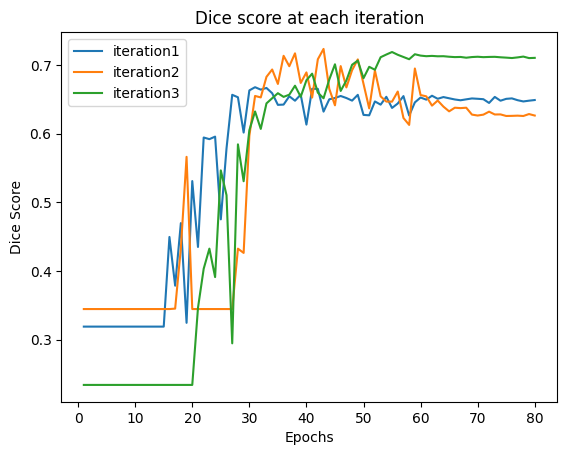

<Figure size 640x480 with 0 Axes>

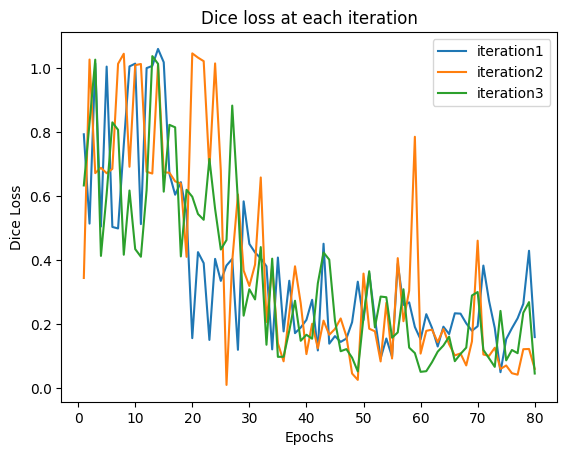

In [ ]:
var = 0 
fig = plt.figure()
fig, ax = plt.subplots()
epochs = range(1, len(kfold_hist[var][1]) + 1)
# plt.plot(epochs, kfold_hist[var][1], 'r', label='Test mDSC')
ax.plot(epochs, kfold_hist[var][1], label='iteration1')
ax.plot(epochs, kfold_hist[var+1][1], label='iteration2')
ax.plot(epochs, hist_T0014[1], label='iteration3')
plt.title('Dice score at each iteration')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()
plt.show()

fig = plt.figure()
fig, ax = plt.subplots()
epochs = range(1, len(kfold_hist[var][0]) + 1)
# plt.plot(epochs, kfold_hist[var][0], 'r', label='Test mDSC')
ax.plot(epochs, kfold_hist[var][0], label='iteration1')
ax.plot(epochs, kfold_hist[var+1][0], label='iteration2')
ax.plot(epochs, hist_T0014[0], label='iteration3')
plt.title('Dice loss at each iteration')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()

# Call best model and get predictions

In [ ]:
def savePred(y_p, sliceNum, TestSubName, path_of_test, path_to_save):
      dataset = []
      # print((TestSubName[0]))
      all_images = glob.glob(os.path.join(path_of_test, TestSubName[0]+'*'))
      image_name = all_images[sliceNum]
      filename = image_name.split('/')[-1]
      print(filename)
      cv2.imwrite(os.path.join(path_to_save, filename), y_p * 255.0)
      return

In [ ]:
dsc_ls = []
prediction = []

testSubName = 'T0013' # change based on iteration
subName = ['T0012', 'T0013', 'T0014']
# kfold_hist = []
# for i, testSubName in enumerate(Y):
# fold_var += 1
# print('Training iteration', fold_var)
testSubName = [testSubName]
trainSubName = list(set(subName)-set(testSubName))
print('testsub: ', testSubName, 'trainSubNames: ', trainSubName)
x_train = getTrain(trainSubName, image_directory)
y_train = getTrain(trainSubName, mask_directory)
x_test = getTest(testSubName, image_directory)
y_test = getTest(testSubName, mask_directory)
print(x_train.shape, x_test.shape)

model = unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.load_weights('/content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/meniscus_epoch80_T0013_dce_074.hdf5')
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(1)
sliceNum = 0
for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        y_batch_val = tf.cast(y_batch_val, dtype='float32')
        y_pred = tf.cast((val_logits>0.5), dtype='float32')
        dsc = DiceCoef(y_batch_val,y_pred)
        dsc_ls.append(dsc.numpy())
        y_p = np.squeeze(y_pred, axis=0)
        # savePred(y_p, sliceNum, testSubName, mask_directory, prediction_directory) # uncomment if plan to save prediction images
        prediction.append((y_p))
        sliceNum += 1
        # prediction = tf.concat(prediction, y_pred)
print(np.mean(dsc_ls))

## Show prediction and label compairson

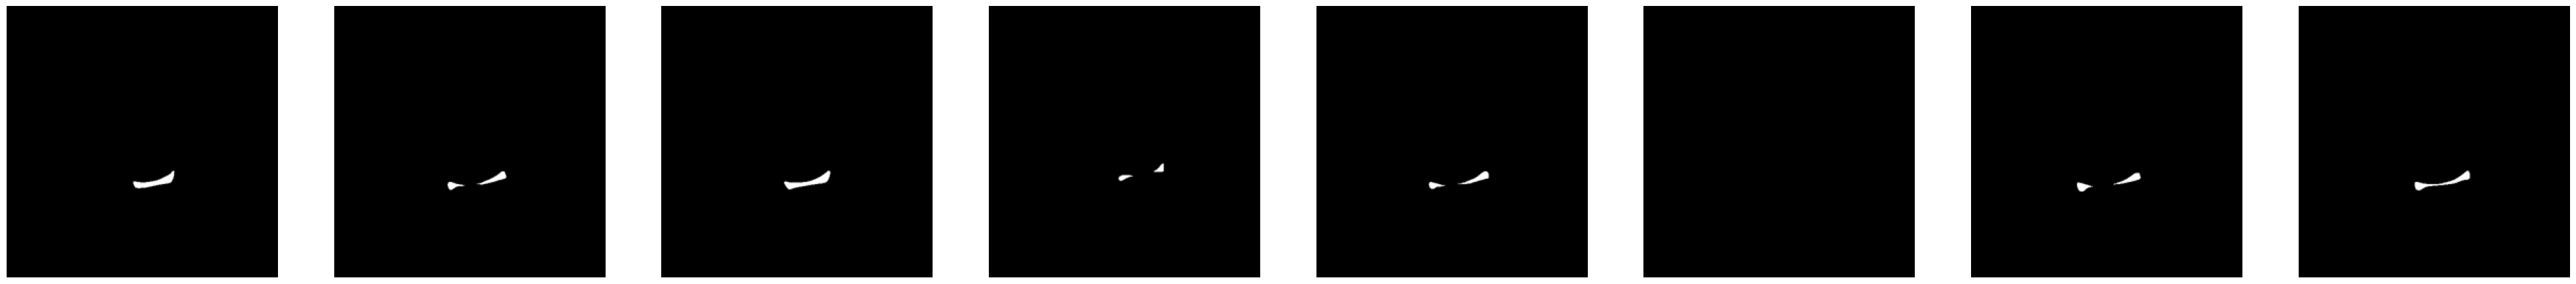

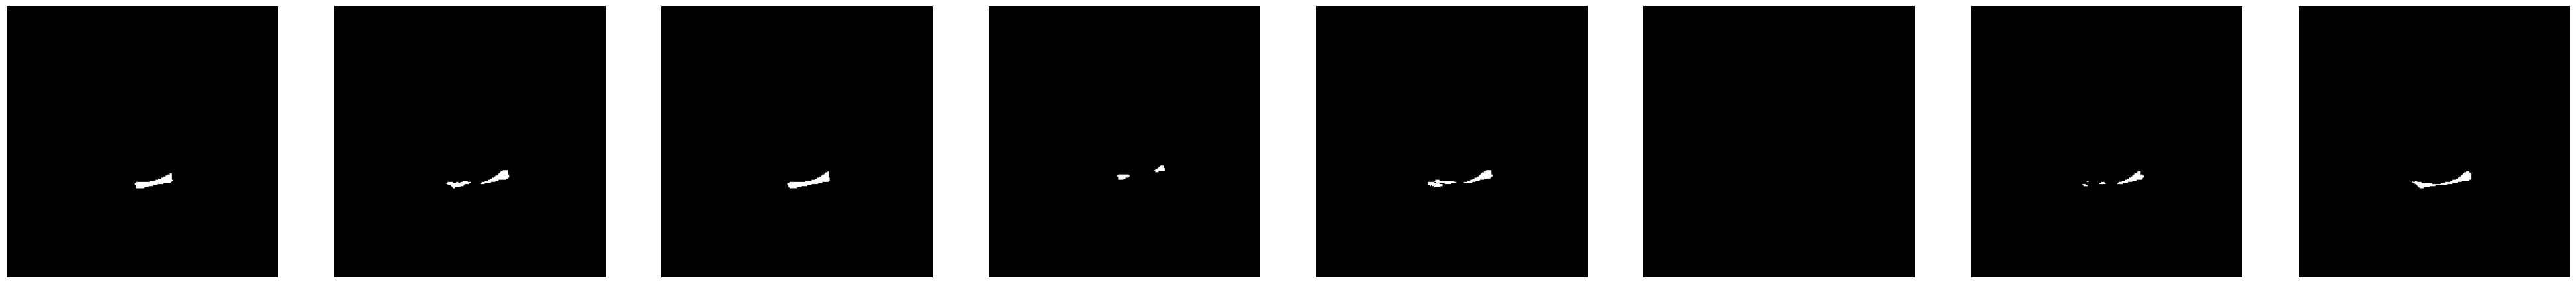

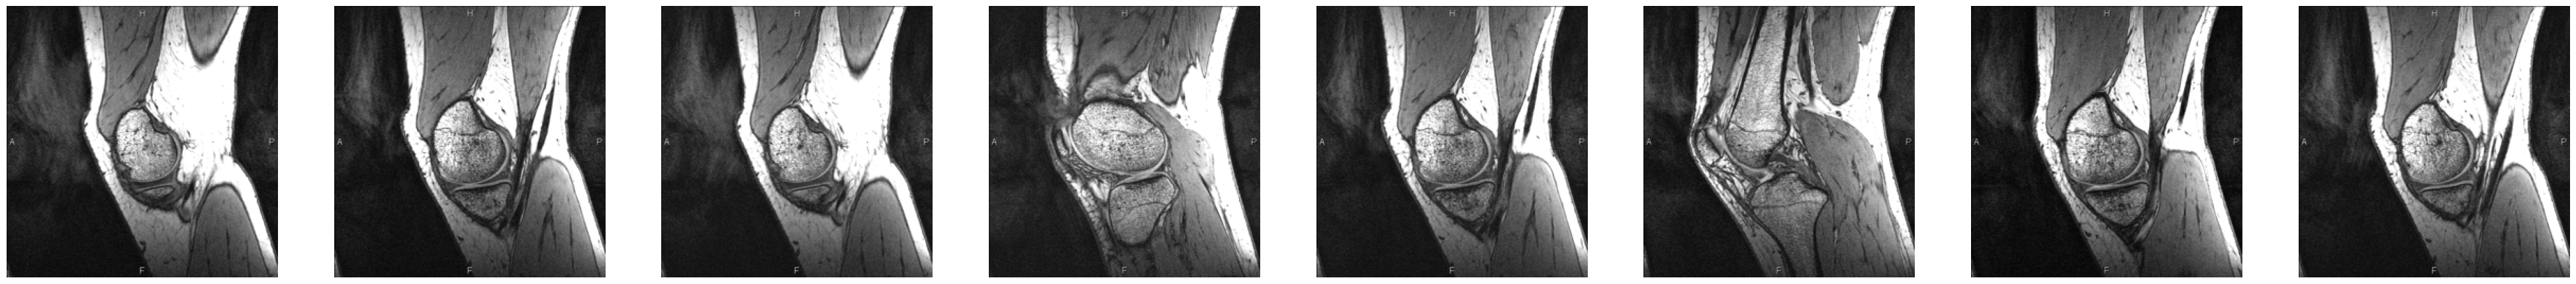

In [ ]:
import matplotlib.gridspec as gridspec
def plot_examples(batch):
    plt.figure(figsize=(50, 50))
    for i in range(len(batch)):
        plt.subplot(8, 8, i+1)
        plt.imshow(batch[i])
        gs1 = gridspec.GridSpec(8, 8)
        gs1.update(wspace=0.0025, hspace=0.05)
#         plt.colorbar()
        plt.axis('off')
        plt.gray()
    plt.show()
    gs1.update(wspace=0.0025, hspace=0.05)
plot_examples(np.sum(y_test[5:13],axis=3)) # display the test images
plot_examples(np.sum(prediction[5:13],axis=3)) # display the test masks
plot_examples(np.sum(x_test[5:13], axis=3)) # display thresholded images